Google colab requiere instalar estas cuatro librerías para poder ejecutar el código

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece
!pip install sentence_transformers
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=8f16bdc41c04ca277691dc1a0c2f0d9e68d01ce677ebee6661f62a5cfc1f815e
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=8495982cedf57b46bbe0365dbd5874e66edb91e331f4451b8f35421ef7fee0c1
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=d8a9eb3872be0eb2a8994c140188a750098605963a77b73223a3cc4d72f2b671
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

import pandas as pd
import re
import numpy as np
import math
from bs4 import BeautifulSoup
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import socket
import pickle
from sentence_transformers import SentenceTransformer
import scipy
import os
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


En Google colab, el dataset se carga desde drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se carga el dataset. Será necesario adaptar la ruta del archivo en función de la ubicación de este. Vemos que tiene 46.844 filas y 9 columnas.

In [ ]:
data_1 = pd.read_csv(
    "/content/drive/MyDrive/workdir/data/df_colas.csv",
    sep= ";"

)

In [ ]:
data_1

,ticket_id,ticket_type,title,customer,create_time,priority,host,solution,queue_path
0,25221.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,VSTI,2020-01-01 00:00:31,3 normal,VSTIP_NEXTCLOUDDB01 - VSTIP_NEXTCLOUDDB01 - NE...,NaN,NaN
1,NaN,NaN,['OPERACION'],NaN,NaN,NaN,NaN,NaN,NaN
2,25222.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,VSTI,2020-01-01 00:00:31,3 normal,VSTIP_NEXTCLOUDAPP01 - VSTIP_NEXTCLOUDAPP01 - ...,NaN,NaN
3,NaN,NaN,['OPERACION'],NaN,NaN,NaN,NaN,NaN,NaN
4,25223.0,Incidencia Interna,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,Toolsgroup,2020-01-01 00:06:55,3 normal,TOOPWIG00004 - TOOPWIG00004,NaN,NaN
...,...,...,...,...,...,...,...,...,...
46839,53608.0,Incidencia Interna,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,BilbaoTIK,2023-02-09 11:10:27,2 low,NaN,NaN,['Negocio']
46840,53609.0,Incidencia Interna,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,BilbaoTIK,2023-02-09 11:10:27,2 low,NaN,NaN,['Negocio']
46841,53610.0,Incidencia Interna,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,BilbaoTIK,2023-02-09 11:40:06,2 low,NaN,NaN,['Negocio']
46842,53611.0,Incidencia Interna,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,BilbaoTIK,2023-02-09 11:40:07,2 low,NaN,NaN,['Negocio']


Vemos que hay muchas celdas con todo NaNs excepto la columna title, que está mal porque aparecen los queue_path. Eliminamos todas esas filas eliminando los valores nulos de la columna ticket_id.

Por otro lado, nos quedamos únicamente con las cuatro columnas que nos interesan: ticket_id, title, solution y queue_path

In [ ]:
data_1.dropna(subset='ticket_id', inplace=True)

data_1=data_1[['ticket_id', 'title', 'solution', 'queue_path']]
data_1

,ticket_id,title,solution,queue_path
0,25221.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
2,25222.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
4,25223.0,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,NaN,NaN
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


El dataset se reduce a 28.294 filas.

In [ ]:
data_1.isna().sum()

ticket_id         0
title             3
solution      26186
queue_path    18550
dtype: int64

De 28294 incidencias, 18550 no tienen grupo asignado y 26186 no tienen solución. Se calcula el total de tickets con grupo asignado y el total de grupos con solución

In [ ]:
grupos_no_nulos = data_1.dropna(subset="queue_path")
con_solucion = data_1.dropna(subset="solution")
print("tickets con grupo :", len(grupos_no_nulos))
print("tickets con solucion :", len(con_solucion))

tickets con grupo : 9744
tickets con solucion : 2108


Se eliminan las incidencias con solución o queue_path nulos

In [ ]:
data_1.dropna(subset=["solution", "queue_path"])

,ticket_id,title,solution,queue_path
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
94,25284.0,SoftTSU,Cerramos incidencia en el sistema de gestión d...,['ADM SISTEMAS']
154,25321.0,Dar permisos a Eduardo Moraleja al vcenter VERSIA,Se realiza el cambio junto con Soporte Usuarios.,['ADM SISTEMAS']
174,25336.0,TICKET_AUT: ** PROBLEM Alerta de servicio: SYC...,Se comprueba que la alerta por bloqueos ya no ...,['ADM SISTEMAS']
181,25342.0,Recuperación IMQ,Se procede a la recuperación del perfil en la ...,['OPERACION']
...,...,...,...,...
46788,53565.0,Re: Errores de inicio de sesión,Se esta revisando desde CAU BAM,['ADM SISTEMAS']
46797,53574.0,Baja monitorizacion,Ya se pidio la baja del servidor en el siguien...,['ADM SISTEMAS']
46801,53578.0,RV: Informe incidencias Enero 2023,Se cambia en la notificaciones de los tickets ...,['ADM SISTEMAS']
46803,53580.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,La version de Horizon actual es 7.12. \r\n\r\n...,"['Negocio', 'Soporte Windows', 'Soporte Vmware']"


Hay un total de 477 secuencias de grupos. Es decir, hay un total de 477 categorías

In [ ]:
grupos_no_nulos["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                                                                                                                              3342
['Soporte Gestion Usuarios']                                                                                                                  1174
['Soporte Utilities PyC']                                                                                                                     1035
['ADM SISTEMAS', 'Soporte BackUp']                                                                                                             445
['SoporteFunc BiscayTIk']                                                                                                                      371
                                                                                                                                              ... 
['SoporteFunc BiscayTIk', 'Soporte Comunicaciones', 'ADM SISTEMAS', 'SoporteFunc BiscayTIk']               

Vemos ahora cuántas categorías hay con más de 15 registros. Un total de 34

In [ ]:
conteo= grupos_no_nulos["queue_path"].value_counts()
cat34= conteo[conteo> 15]

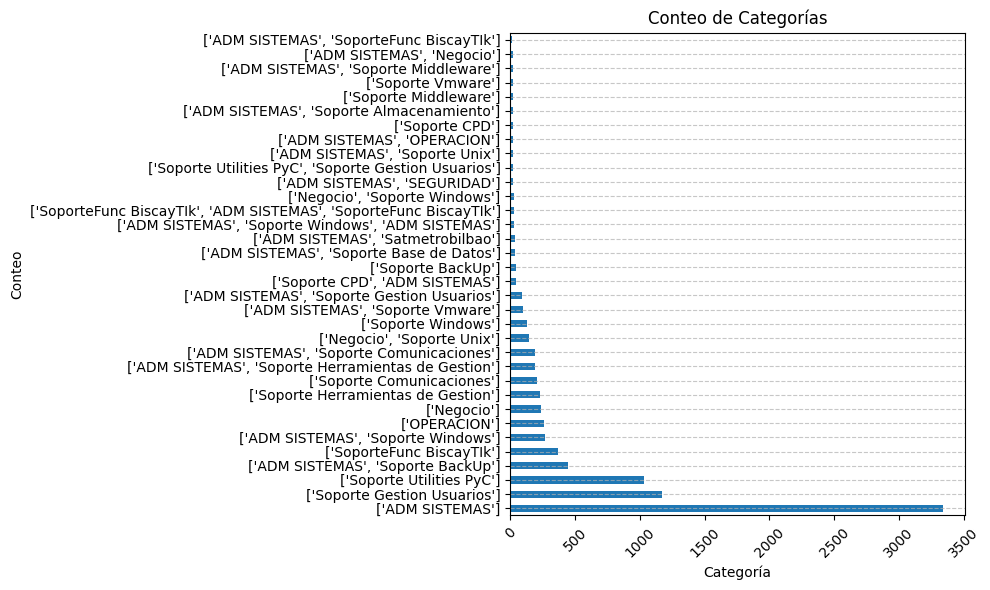

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
cat34.plot(kind='barh')
plt.title('Conteo de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Esta es la distribución de las 34 categorías más frecuentes. 17 de ellas cuentan aún con muy pocos registros.Se muestran ahora los 15 grupos más frecuentes y la distribución de los grupos

In [ ]:
cat15 = grupos_no_nulos.groupby("queue_path")['ticket_id'].count().reset_index().sort_values('ticket_id', ascending=False)
cat15[:15]  # 15 grupos para categorizar

,queue_path,ticket_id
182,['ADM SISTEMAS'],3342
397,['Soporte Gestion Usuarios'],1174
429,['Soporte Utilities PyC'],1035
51,"['ADM SISTEMAS', 'Soporte BackUp']",445
476,['SoporteFunc BiscayTIk'],371
176,"['ADM SISTEMAS', 'Soporte Windows']",267
264,['OPERACION'],258
254,['Negocio'],235
412,['Soporte Herramientas de Gestion'],229
389,['Soporte Comunicaciones'],205


In [ ]:
sum(cat15['ticket_id'][:15])


8306

<Axes: >

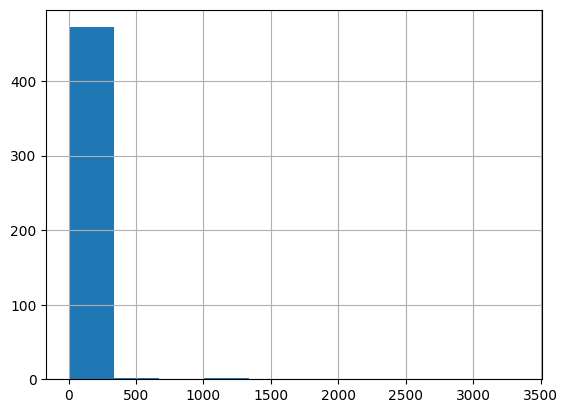

In [ ]:
data_1["queue_path"].value_counts().hist()

La mayoría de los grupos tienen una frecuencia de entre 0 y 400 incidencias aproximadamente. Únicamente hay 4 grupos por encima de ese rango

In [ ]:
data_1.dropna(subset= "ticket_id")

,ticket_id,title,solution,queue_path
0,25221.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
2,25222.0,TICKET_AUT: ** PROBLEM Alerta de Host: VSTIP_N...,NaN,NaN
4,25223.0,TICKET_AUT: ** PROBLEM Alerta de servicio: TOO...,NaN,NaN
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


In [ ]:
data= grupos_no_nulos
data

,ticket_id,title,solution,queue_path
6,25224.0,TICKET_AUT: licencia servidor backup cires,Se rearma la licencia de evaluacion.,['Soporte BackUp']
7,25225.0,Tareas de mantenimiento Sidenor,NaN,['Soporte Windows']
10,25227.0,Ifaces y vlanes 02/01/2020,NaN,['Soporte Herramientas de Gestion']
11,25228.0,Alta / Modificación Usuario - Resetear contras...,NaN,['Soporte Gestion Usuarios']
12,25229.0,Alta / Modificación Usuario - Resetear contras...,NaN,['Soporte Gestion Usuarios']
...,...,...,...,...
46839,53608.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46840,53609.0,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,NaN,['Negocio']
46841,53610.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']
46842,53611.0,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,NaN,['Negocio']


Ahora guardo dos variables, una para el clasificador y otra con soluciones para la interfaz posterior

In [ ]:
data_1= data.drop(["solution", "ticket_id"], axis=1)
data_2= data.drop(["ticket_id", "queue_path"], axis= 1)

In [ ]:
data_1

,title,queue_path
6,TICKET_AUT: licencia servidor backup cires,['Soporte BackUp']
7,Tareas de mantenimiento Sidenor,['Soporte Windows']
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion']
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']


In [ ]:
data_1["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                                                                                                                              3342
['Soporte Gestion Usuarios']                                                                                                                  1174
['Soporte Utilities PyC']                                                                                                                     1035
['ADM SISTEMAS', 'Soporte BackUp']                                                                                                             445
['SoporteFunc BiscayTIk']                                                                                                                      371
                                                                                                                                              ... 
['SoporteFunc BiscayTIk', 'Soporte Comunicaciones', 'ADM SISTEMAS', 'SoporteFunc BiscayTIk']               

Se visualizan las 10 categorías más frecuentes y se decide trabajar únicamente con ellas para disponer de un número razonable de muestras en cada categoría a clasificar.

In [ ]:
conteo= data_1["queue_path"].value_counts()
cat10= conteo[conteo>=200]
cat10


queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1035
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

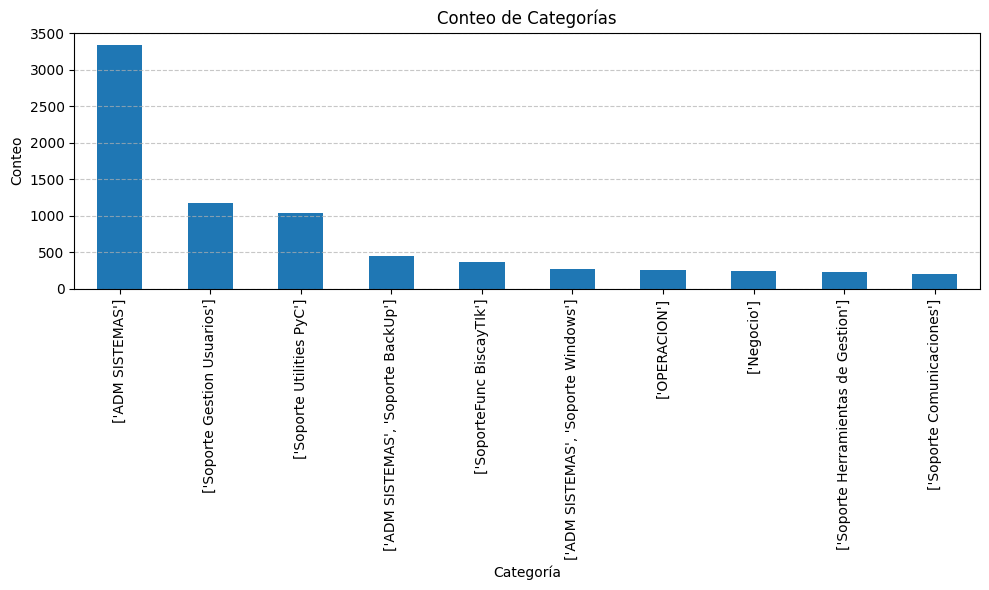

In [ ]:
plt.figure(figsize=(10, 6))
cat10.plot(kind='bar')
plt.title('Conteo de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Conteo')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se aprecia un desbalanceo obvio. No obstante, se han realizado pruebas con técnicas como SMOTE o RandomOverSampling y no se obtienen buenos resultados. Se decide trabajar con el conjunto tal cual está

In [ ]:
cat10= cat10.index.tolist()


Ahora se crea el dataset con el que se va a trabajar añadiendo únicamente las 10 categorías más frecuentes, almacenadas en la variable cat10

In [ ]:
data_final= data_1[data_1["queue_path"].isin(cat10)]
data_final

,title,queue_path
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion']
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios']
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS']
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS']
...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio']
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio']


In [ ]:
data_final= data_final.dropna()

Y esta es la distribución de las categorías que habrá que clasificar.

In [ ]:
data_final["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1034
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

## Limpieza

Se definen estas funciones para limpiar el texto. Se eliminan tags HTML, URLs, signos de puntuación, caracteres especiales, números y expacios en blanco extra

In [ ]:
def remove_html_tags_func(text): # Esta función elimina cualquier tag HTML que pueda haber en alguna incidencia.

    return BeautifulSoup(text, 'html.parser').get_text()


def remove_url_func(text): # Esta se encarga de eliminar posibles URLs que no hacen más que aumentar el ruido de los datos.

    return re.sub(r'https?://\S+|www\.\S+', '', text)


def remove_punctuation_func(text): # Se eliminan signos de puntuación como comas, puntos etc para facilitar la tokenización

    return re.sub(r'[^a-zA-Z0-9]', ' ', text)


def remove_irr_char_func(text): # Se eliminan números

    return re.sub(r'[^a-zA-Z]', ' ', text)


def remove_extra_whitespaces_func(text): # Al aplicar las funciones anteriores, muchos de los elementos eliminados se sustituyen por espacios en blanco. Esto puede dificultar la tokenización --> Se eliminan.

    return re.sub(r'^\s*|\s\s*', ' ', text).strip()






Ya con las funciones definidas se aplican a la columna title que contiene los textos y se crea la columna clean_title

In [ ]:
#data_final['clean_title'] = data_final['title'].str.lower()
data_final['clean_title'] = data_final['title'].apply(remove_html_tags_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_url_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_punctuation_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_irr_char_func)
data_final['clean_title'] = data_final['clean_title'].apply(remove_extra_whitespaces_func)



<ipython-input-31-877f3f2df18d>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
<ipython-input-32-6334bec01107>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['clean_title'] = data_final['title'].apply(remove_html_tags_func)
<ipython-input-32-6334bec01107>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['clean_title'] 

In [ ]:
data_final

,title,queue_path,clean_title
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion'],Ifaces y vlanes
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS'],Errores con el correo de producci n de IPTN
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],Solicitud de cambio de cintas justicia
...,...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...


Se dispone de 7560 incidencias

In [ ]:
data_final["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       3342
['Soporte Gestion Usuarios']           1174
['Soporte Utilities PyC']              1034
['ADM SISTEMAS', 'Soporte BackUp']      445
['SoporteFunc BiscayTIk']               371
['ADM SISTEMAS', 'Soporte Windows']     267
['OPERACION']                           258
['Negocio']                             235
['Soporte Herramientas de Gestion']     229
['Soporte Comunicaciones']              205
Name: count, dtype: int64

In [ ]:
data_final["queue_path"].unique()

array(["['Soporte Herramientas de Gestion']",
       "['Soporte Gestion Usuarios']", "['ADM SISTEMAS']",
       "['Soporte Comunicaciones']", "['Soporte Utilities PyC']",
       "['OPERACION']", "['ADM SISTEMAS', 'Soporte BackUp']",
       "['ADM SISTEMAS', 'Soporte Windows']", "['SoporteFunc BiscayTIk']",
       "['Negocio']"], dtype=object)

Como el modelo necesita categorías numéricas y los grupos están en cadenas de texto, se crea un diccionario asignando un número a cada grupo para hacer después un mapeo

In [ ]:
categorias_dict = {
    "['ADM SISTEMAS']": 0,
    "['Soporte Gestion Usuarios']": 1,
    "['Soporte Utilities PyC']": 2,
    "['ADM SISTEMAS', 'Soporte BackUp']": 3,
    "['SoporteFunc BiscayTIk']": 4,
    "['ADM SISTEMAS', 'Soporte Windows']": 5,
    "['OPERACION']": 6,
    "['Negocio']": 7,
    "['Soporte Herramientas de Gestion']": 8,
    "['Soporte Comunicaciones']": 9
}

In [ ]:
data_final["categoria"]= data_final["queue_path"].map(categorias_dict)

<ipython-input-37-1617d5e0342c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final["categoria"]= data_final["queue_path"].map(categorias_dict)


In [ ]:
data_final

,title,queue_path,clean_title,categoria
10,Ifaces y vlanes 02/01/2020,['Soporte Herramientas de Gestion'],Ifaces y vlanes,8
11,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
12,Alta / Modificación Usuario - Resetear contras...,['Soporte Gestion Usuarios'],Alta Modificaci n Usuario Resetear contrase a ...,1
30,Errores con el correo de producción de IPTN,['ADM SISTEMAS'],Errores con el correo de producci n de IPTN,0
31,Solicitud de cambio de cintas justicia,['ADM SISTEMAS'],Solicitud de cambio de cintas justicia,0
...,...,...,...,...
46839,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46840,[JIRA] (SISTEMAS-2394) Instalación de aplicaci...,['Negocio'],JIRA SISTEMAS Instalaci n de aplicaci n docker...,7
46841,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7
46842,[JIRA] (SISTEMAS-2440) Validar la compatibilid...,['Negocio'],JIRA SISTEMAS Validar la compatibilidad de Hor...,7


Se divide el dataset en train, test y validation manteniendo las proporciones de los grupos con el stratify. Como hay pocos datos se hace la división 60-20-20 para que haya suficientes datos en test y validation. No obstante, se han probado diferentes particiones, y esta es la que mejores resultados ofrece porque se mantienen suficientes datos en el conjunto de entrenamiento para que el modelo identifique patrones y al mismo tiempo los conjuntos de test y validación cuentan con suficientes muestras de cada clase.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_final, test_size=0.2, stratify=data_final['queue_path'])


In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['queue_path'])


Estas son las distribuciones en cada conjunto de datos.

In [ ]:
train_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       2139
['Soporte Gestion Usuarios']            751
['Soporte Utilities PyC']               662
['ADM SISTEMAS', 'Soporte BackUp']      285
['SoporteFunc BiscayTIk']               238
['ADM SISTEMAS', 'Soporte Windows']     171
['OPERACION']                           165
['Negocio']                             150
['Soporte Herramientas de Gestion']     146
['Soporte Comunicaciones']              131
Name: count, dtype: int64

In [ ]:
test_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       668
['Soporte Gestion Usuarios']           235
['Soporte Utilities PyC']              207
['ADM SISTEMAS', 'Soporte BackUp']      89
['SoporteFunc BiscayTIk']               74
['ADM SISTEMAS', 'Soporte Windows']     53
['OPERACION']                           52
['Negocio']                             47
['Soporte Herramientas de Gestion']     46
['Soporte Comunicaciones']              41
Name: count, dtype: int64

In [ ]:
val_df["queue_path"].value_counts()

queue_path
['ADM SISTEMAS']                       535
['Soporte Gestion Usuarios']           188
['Soporte Utilities PyC']              165
['ADM SISTEMAS', 'Soporte BackUp']      71
['SoporteFunc BiscayTIk']               59
['ADM SISTEMAS', 'Soporte Windows']     43
['OPERACION']                           41
['Negocio']                             38
['Soporte Herramientas de Gestion']     37
['Soporte Comunicaciones']              33
Name: count, dtype: int64

Se crea el tokenizador de bert que se va a utilizar. Para ello se carga el modelo preentrenado. En este caso se utiliza un modelo multilingüe capaz de distinguir entre mayúsculas y minúsculas. Sus especificaciones están detalladas en la memoria del proyecto.

In [ ]:
FullTokenizer= bert.bert_tokenization.FullTokenizer

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)
vocab_file= bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case= bert_layer.resolved_object.do_lower_case.numpy()
tokenizer= FullTokenizer(vocab_file, do_lower_case)


Se crea ahora esta función para realizar la tokeniación y se añaden los tokens especiales. En el otro modelo esta función convierte directamente los tokens en ids numéricos, pero en este caso es necesario modificar la estructura de los inputs, por tanto se convierten en ids más adelante.

In [ ]:
def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]

Se definen ahora tanto los inputs como las labels (etiquetas) para cada conjunto de datos

In [ ]:
inputs= [encode_sentence(sentence) for sentence in data_final["clean_title"]] # Ahora el input todavía no es numérico.

In [ ]:
train_inputs= [encode_sentence(sentence) for sentence in train_df["clean_title"]]
test_inputs= [encode_sentence(sentence) for sentence in test_df["clean_title"]]
val_inputs= [encode_sentence(sentence) for sentence in val_df["clean_title"]]

In [ ]:
labels= data_final["categoria"].values
labels_train= train_df["categoria"].values
labels_test= test_df["categoria"].values
labels_val= val_df["categoria"].values

Esta función se hace porque si alguna incidencia tiene una longitud superior a 512 tokens habrá que realizar alguna modificación, pero en este caso la incidencia más larga está compuesta por 83 tokens por lo que no hay problema.

In [ ]:
# Conteo de tokens

def count_tokens(text):
    token_ids = encode_sentence(text)
    return len(token_ids)

data_final['Num_tokens'] = data_final['clean_title'].apply(count_tokens)


<ipython-input-50-13b73158a9d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['Num_tokens'] = data_final['clean_title'].apply(count_tokens)


In [ ]:
data_final.describe()

,categoria,Num_tokens
count,7560.000000,7560.000000
mean,1.887037,18.799074
std,2.495386,11.258756
min,0.000000,2.000000
25%,0.000000,11.000000
50%,1.000000,15.000000
75%,3.000000,23.000000
max,9.000000,83.000000


Se definen tres funciones explicadas en la memoria del proyecto. La primera es para convertir los tokens en ids numéricos como se comentaba anteriormente, la segunda es para crear las máscaras de atención y que el modelo se centre en los tokens realmente importantes y la tercera para asignar el identificador de segmentos.

In [ ]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)  # Se convirten los tokens en ids

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)  # Busca en la lista de tokens el token PAD, que no nos interesa. Esto le permite al modelo centrarse en los tokens importantes
    # nor equal a PAD --> Devuelve 1 si no es PAD y 0 si lo es

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # convierte los 1 en 0 y vice versa
    return seg_ids

    # Esta última es para saber si la frase va delante o detrás. Las de delante del separador 0, las de detrás 1


Aquí se crea el dataset en formato TensorFlow que Bert puede procesar. Es igual que en el otro modelo pero añadiéndole las 3 funciones. Es en este paso donde se convierten los tokens en ids numéricos. Además, sorted_all estará formado también por dos arrays, una indicando si es un token de relleno o uno relevante, y la otra especificando el segmento al que pertenece el token.

In [ ]:
data_with_len = [[sent, labels[i], len(sent)]
                 for i, sent in enumerate(inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 4]

all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))




Igual que en el otro modelo, se repite el proceso pero para cada conjunto de datos. Estos son los que se van a utilizar en el modelo, el anterior es de "muestra".

In [ ]:
# train
data_with_len_train = [[sent, labels_train[i], len(sent)]
                 for i, sent in enumerate(train_inputs)]
random.shuffle(data_with_len_train)
data_with_len_train.sort(key=lambda x: x[2])
sorted_all_train = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len_train if sent_lab[2] > 4]

all_dataset_train = tf.data.Dataset.from_generator(lambda: sorted_all_train,
                                             output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_train= all_dataset_train.padded_batch(BATCH_SIZE, padded_shapes= ((3, None ), ()), padding_values= (0, 0))


# test
data_with_len_test = [[sent, labels_test[i], len(sent)]
                 for i, sent in enumerate(test_inputs)]
random.shuffle(data_with_len_test)
data_with_len_test.sort(key=lambda x: x[2])
sorted_all_test = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len_test if sent_lab[2] > 4]

all_dataset_test = tf.data.Dataset.from_generator(lambda: sorted_all_test,
                                             output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_test= all_dataset_test.padded_batch(BATCH_SIZE, padded_shapes= ((3, None ), ()), padding_values= (0, 0))

# Validation
data_with_len_val = [[sent, labels_val[i], len(sent)]
                 for i, sent in enumerate(val_inputs)]
random.shuffle(data_with_len_val)
data_with_len_val.sort(key=lambda x: x[2])
sorted_all_val = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len_val if sent_lab[2] > 4]

all_dataset_val = tf.data.Dataset.from_generator(lambda: sorted_all_val,
                                             output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched_val= all_dataset_val.padded_batch(BATCH_SIZE, padded_shapes= ((3, None ), ()), padding_values= (0, 0))

Se especifica también el tamaño de los lotes y se realiza el padding para que todas las secuencias de cada lote tengan la misma longitud.

padded_shapes habla de la forma de los elementos. El primer elemento hace referencia a las características, siendo (3, None) porque la primera dimensión tiene que ser 3 y la segunda puede variar. El segundo hace referencia a las etiquetas. Por otro lado se indica que los valores de relleno en ambos casos sean 0.


In [ ]:
BATCH_SIZE = 32
all_batched= all_dataset.padded_batch(BATCH_SIZE, padded_shapes= ((3, None ), ()), padding_values= (0, 0)) # Dejándolo vacío no cambia. Se convervan la longitud de las frases y la dimensión de las etiquetas


In [ ]:
#NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
#NB_BATCHES_TEST = NB_BATCHES // 10
#all_batched.shuffle(NB_BATCHES)
#test_dataset = all_batched.take(NB_BATCHES_TEST)
#train_dataset = all_batched.skip(NB_BATCHES_TEST)

train_dataset= all_batched_train
test_dataset= all_batched_test
val_dataset= all_batched_val

Aquí se crea la arquitectura del modelo. Difiere del otro en la función embed_with_bert, que realiza los embeddings con la capa de Bert

In [ ]:

class DCNN(tf.keras.Model):

    def __init__(self,
                    vocab_size,
                    #emb_dim=128,
                    nb_filters=50,
                    FFN_units=512,
                    nb_classes=2,
                    dropout_rate=0.1,
                    training=False,
                    name="dcnn"):
        super(DCNN, self).__init__(name=name)

        self.bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1", trainable=False)



        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()

        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                            activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                            activation="softmax")

    def embed_with_bert(self, all_tokens):
        _, embs= self.bert_layer([all_tokens[:, 0, :],
                                  all_tokens[:, 1, :],
                                  all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x= self.embed_with_bert(inputs)  # Este suele ser el tensor
        x_1 = self.bigram(x)  # (batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1)  # (batch_size, nb_filters)
        x_2 = self.trigram(x)  # (batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2)  # (batch_size, nb_filters)
        x_3 = self.fourgram(x)  # (batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3)  # (batch_size, nb_filters)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training= training)
        output = self.last_dense(merged)

        return output

Aquí se especifican los hiperparámetros del modelo y los criterios para compilarlo.

In [ ]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 64
FFN_UNITS = 128
NB_CLASSES = data_final.categoria.nunique()

DROPOUT_RATE = 0.5

NB_EPOCHS = 30  # 5

Dcnn = DCNN(vocab_size= VOCAB_SIZE,
            #emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                    optimizer="adam",
                    metrics=["sparse_categorical_accuracy"])




Estas celdas comentadas son para crear el checkpoint utilizado para no tener que estar cada vez que se abra el notebook entrenando el modelo.

In [ ]:
#model_path= "/content/drive/MyDrive/checkpoints"

In [ ]:
#checkpoint_path = model_path

#ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

    #if ckpt_manager.latest_checkpoint:
     #   ckpt.restore(ckpt_manager.latest_checkpoint)
      #  print("Último checkpoint restaurado!!")

Se define el early_stopping y su criterio de parada. Monitoria la función de pérdida en el conjunto de validación con una paciencia de tres épocas, por lo que si pasan tres épocas seguidas sin disminuir la pérdida en el conjunto de validación el entrenamiento parará quedándose con las métricas de la época con la pérdida mínima.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=3,
                                                      restore_best_weights=True)

#class MyCustomCallback(tf.keras.callbacks.Callback):

 #   def on_epoch_end(self, epoch, logs=None):
  #      ckpt_manager.save()
   #     print("Checkpoint guardado en {}.".format(checkpoint_path))




Se entrena el modelo especificándole que entrene con el conjunto de entrenamiento y que realice la validación con el conjunto de validación. Con el early_stopping para en la época 10, quedándose con las métricas de la época 7 antes de empezar a sobreajustarse. En esa época la accuracy del entrenamiento es del 91,38% y la del conjunto de validación del 86,42% con una pérdida de 0,4872.

Entrena más épocas que el otro modelo, pero la accuracy en el entrenamiento es menor. Esto es porque se ha establecido la tasa de dropout en 0,5 para prevenir el sobreajuste, por lo que requiere de más épocas para aprender relaciones entre los datos

In [ ]:
history= Dcnn.fit(train_dataset,
        epochs=NB_EPOCHS,
        validation_data= val_dataset,
       # callbacks=[MyCustomCallback(), early_stopping])
       callbacks= [early_stopping])

Epoch 1/30
151/151 [==============================] - 48s 222ms/step - loss: 1.0606 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.9266 - val_sparse_categorical_accuracy: 0.6775
Epoch 2/30
151/151 [==============================] - 10s 68ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7801 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.7800
Epoch 3/30
151/151 [==============================] - 10s 68ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.5452 - val_sparse_categorical_accuracy: 0.8100
Epoch 4/30
151/151 [==============================] - 11s 71ms/step - loss: 0.4298 - sparse_categorical_accuracy: 0.8495 - val_loss: 0.5218 - val_sparse_categorical_accuracy: 0.8342
Epoch 5/30
151/151 [==============================] - 11s 73ms/step - loss: 0.3374 - sparse_categorical_accuracy: 0.8797 - val_loss: 0.4903 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/30
151/151 [==============================] - 10s 67ms/step - loss: 0.2754 - spar

A continuación se visualizan las curvas de la pérdida y la accuracy en los conjuntos de entrenamiento y validación. La explicación de estas se encuentra en la memoria del proyecto.

<ipython-input-63-6c5110a4f60c>:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo-', label='Training Loss', marker= "o")


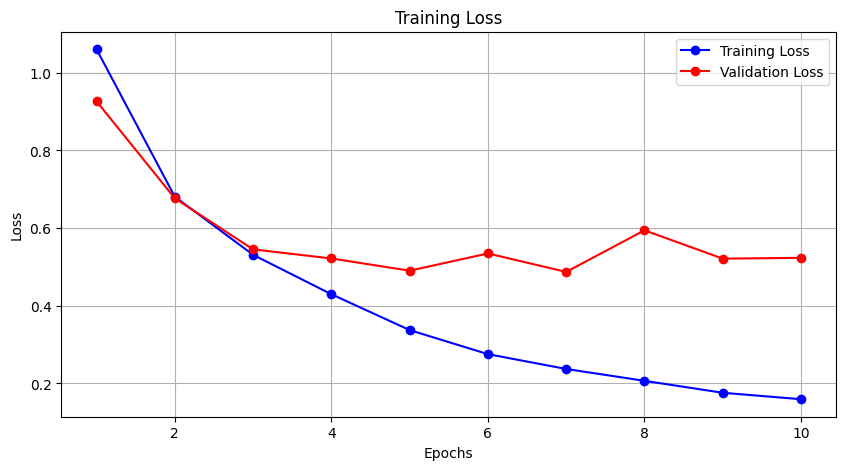

<ipython-input-63-6c5110a4f60c>:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy', marker= "o")


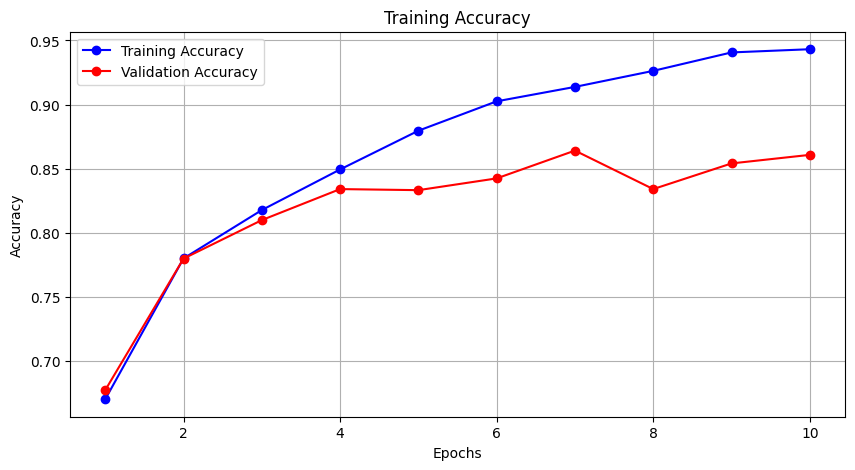

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history["val_loss"]
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy= history.history["val_sparse_categorical_accuracy"]
epochs = range(1, len(loss) + 1)

# Plot de loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss', marker= "o")
plt.plot(epochs, val_loss, 'r-', label='Validation Loss', marker= "o")
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot de accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy', marker= "o")
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy', marker= "o")

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Se evalúa el rendimiento del modelo en el conjunto de prueba obteniendo un accuracy del 85,89% y una pérdida de 0,4552.

In [ ]:
results = Dcnn.evaluate(test_dataset)
print(results)


47/47 [==============================] - 3s 65ms/step - loss: 0.4552 - sparse_categorical_accuracy: 0.8589
[0.4552193582057953, 0.8589487671852112]


In [ ]:
results

[0.4552193582057953, 0.8589487671852112]

In [ ]:
df_maestro= data_final[["queue_path", "categoria"]].drop_duplicates().reset_index().sort_values(by= "categoria", ascending= True)
df_maestro= df_maestro.drop("index", axis= 1)
df_maestro

,queue_path,categoria
2,['ADM SISTEMAS'],0
1,['Soporte Gestion Usuarios'],1
4,['Soporte Utilities PyC'],2
6,"['ADM SISTEMAS', 'Soporte BackUp']",3
8,['SoporteFunc BiscayTIk'],4
7,"['ADM SISTEMAS', 'Soporte Windows']",5
5,['OPERACION'],6
9,['Negocio'],7
0,['Soporte Herramientas de Gestion'],8
3,['Soporte Comunicaciones'],9


Creo las matrices de confusión y el classification report para los conjuntos de train y test. Al estar los datos en un formato de tensorflow no se puede hacer de la forma habitual. Creo una lista vacía y luego un bucle para ir iterando por cada predicción del modelo y que estas se añadan a la lista.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Sólo train

y_true = []
y_pred = []

# Entrenamiento
for batch in train_dataset:
    features, labels = batch
    predictions = Dcnn(features, training=False)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convertir a arrays de numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2119
           1       0.98      0.99      0.99       750
           2       0.97      1.00      0.98       656
           3       0.91      0.64      0.75       284
           4       1.00      0.99      0.99       238
           5       0.96      0.62      0.76       165
           6       0.97      0.95      0.96       165
           7       1.00      0.97      0.99       150
           8       0.87      0.94      0.90       145
           9       0.98      0.93      0.96       131

    accuracy                           0.95      4803
   macro avg       0.96      0.90      0.92      4803
weighted avg       0.95      0.95      0.94      4803



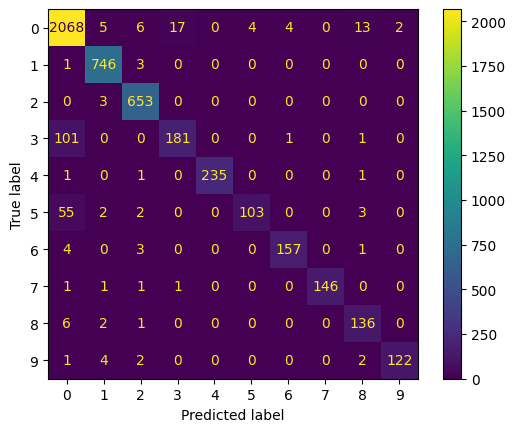

<Figure size 1500x1000 with 0 Axes>

In [ ]:
classes_ = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels= classes_).plot()
plt.figure(figsize= (15,10))

print(classification_report(y_true, y_pred))

<function matplotlib.pyplot.show(close=None, block=None)>

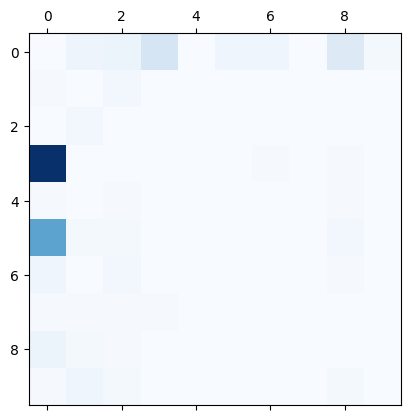

In [ ]:
np.fill_diagonal(cm, 0)
plt.matshow(cm, cmap= "Blues")
plt.show

Ahora modifico la matriz de confusión para ver de una forma más clara cuáles son las columnas que más fallan. Hay que verlo con perspectiva y tener en cuenta que las clases están desbalanceadas. Si una categoría que aparece 600 veces la predice mal en 20 ocasiones y una que aparece en 40 ocasiones la predice mal 15, aparecerá en un azul más oscuro la primera de ellas pero realmente la está clasificando mejor que la segunda.

Dicho esto, se repite el proceso pero con el conjunto de test.

In [ ]:
# Sólo test

y_true = []
y_pred = []

for batch in test_dataset:
    features, labels = batch
    predictions = Dcnn(features, training=False)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convertir a arrays de numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       665
           1       0.91      0.96      0.93       235
           2       0.85      0.96      0.90       206
           3       0.77      0.42      0.54        86
           4       0.99      0.97      0.98        74
           5       0.71      0.23      0.34        53
           6       0.90      0.88      0.89        52
           7       1.00      0.89      0.94        47
           8       0.53      0.70      0.60        44
           9       0.71      0.73      0.72        41

    accuracy                           0.86      1503
   macro avg       0.82      0.77      0.77      1503
weighted avg       0.86      0.86      0.85      1503



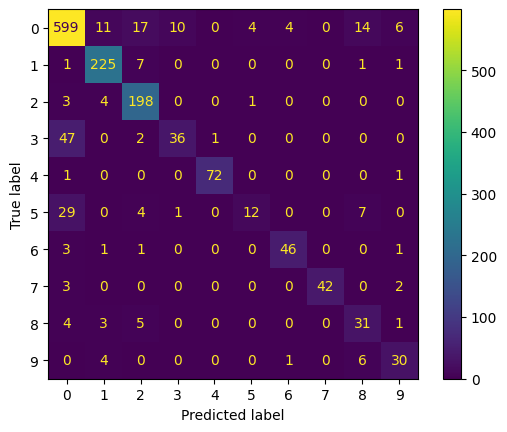

<Figure size 1500x1000 with 0 Axes>

In [ ]:
classes_ = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels= classes_).plot()
plt.figure(figsize= (15,10))

print(classification_report(y_true, y_pred))

<function matplotlib.pyplot.show(close=None, block=None)>

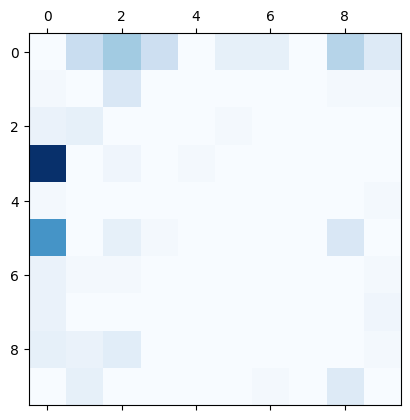

In [ ]:
np.fill_diagonal(cm, 0)
plt.matshow(cm, cmap= "Blues")
plt.show

El conjunto de entrenamiento cuenta con una accuracy de 0,95 mientras que el conjunto de prueba se queda en un 0,86. Se puede ver que el otro modelo ofrece mejores resultados. En la memoria del proyecto se explica mejor todo este apartado.